<img align="right" width="400" src="https://www.fhnw.ch/de/++theme++web16theme/assets/media/img/fachhochschule-nordwestschweiz-fhnw-logo.svg" alt="FHNW Logo">


# CNN Text Classifier

by Fabian Märki

## Summary
The aim of this notebook is to program a CNN text classifier. Additionally, it sets the stage for a later hyperparameter tuning also allowing for model design optimization.

<a href="https://colab.research.google.com/github/markif/2021_HS_DAS_NLP_Notebooks/blob/master/04_a_CNN_Text_Classifier.ipynb">
  <img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [1]:
!pip install 'fhnw-nlp-utils>=0.1.6,<0.2'

from fhnw.nlp.utils.storage import load_dataframe
from fhnw.nlp.utils.storage import download
from fhnw.nlp.utils.colab import runs_on_colab

import numpy as np
import pandas as pd

import tensorflow as tf

print("Tensorflow version:", tf.__version__)

#physical_devices = tf.config.list_physical_devices('GPU') 
#tf.config.experimental.set_memory_growth(physical_devices[0], True)
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
for device in gpu_devices:
    tf.config.experimental.set_memory_growth(device, True)

print("GPU is", "available" if tf.config.list_physical_devices("GPU") else "NOT AVAILABLE")

You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
Tensorflow version: 2.5.1
GPU is available


In [2]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [3]:
%%time
download("https://drive.google.com/uc?id=19AFeVnOfX8WXU4_3rM7OFoNTWWog_sb_", "data/german_doctor_reviews_tokenized.parq")
data = load_dataframe("data/german_doctor_reviews_tokenized.parq")

download("https://drive.google.com/uc?id=1tT2dj70GLi2bJYg4j3g1MIglGXTDAugI", "data/german_doctor_reviews_augmented_tokenized.parq")
data_aug = load_dataframe("data/german_doctor_reviews_augmented_tokenized.parq")

CPU times: user 15 s, sys: 2.52 s, total: 17.5 s
Wall time: 9.23 s


In [4]:
# remove all neutral sentimens
data = data.loc[(data["label"] != "neutral")]
data.shape

(331187, 10)

In [5]:
data.head(3)

,text_original,rating,text,label,sentiment,token_clean,text_clean,token_lemma,token_stem,token_clean_stopwords
0,Ich bin franzose und bin seit ein paar Wochen ...,2.0,Ich bin franzose und bin seit ein paar Wochen ...,positive,1,"[ich, bin, franzose, und, bin, seit, ein, paar...",ich bin franzose und bin seit ein paar wochen ...,"[franzose, seit, paar, wochen, muenchen, zahn,...","[franzos, seit, paar, woch, muench, ., zahn, s...","[franzose, seit, paar, wochen, muenchen, ., za..."
1,Dieser Arzt ist das unmöglichste was mir in me...,6.0,Dieser Arzt ist das unmöglichste was mir in me...,negative,-1,"[dieser, arzt, ist, das, unmöglichste, was, mi...",dieser arzt ist das unmöglichste was mir in me...,"[arzt, unmöglichste, leben, je, begegnen, unfr...","[arzt, unmog, leb, je, begegnet, unfreund, ,, ...","[arzt, unmöglichste, leben, je, begegnet, unfr..."
2,Hatte akute Beschwerden am Rücken. Herr Magura...,1.0,Hatte akute Beschwerden am Rücken. Herr Magura...,positive,1,"[hatte, akute, beschwerden, am, rücken, ., her...",hatte akute beschwerden am rücken . herr magur...,"[akut, beschwerden, rücken, magura, erste, arz...","[akut, beschwerd, ruck, ., magura, erst, arzt,...","[akute, beschwerden, rücken, ., magura, erste,..."


In [6]:
data_aug.head(3)

,text_original,rating,sentiment,text,label,token_clean,text_clean,token_lemma,token_stem,token_clean_stopwords
1,Dieser Arzt ist das unmöglichste was mir in me...,6.0,-1,Dieser Arzt ist das unmöglichste was mir in me...,negative,"[dieser, arzt, ist, das, unmöglichste, was, mi...",dieser arzt ist das unmöglichste was mir in me...,"[arzt, unmöglichste, leben, je, begegnen, unfr...","[arzt, unmog, leb, je, begegnet, unfreund, ,, ...","[arzt, unmöglichste, leben, je, begegnet, unfr..."
1,Dieser Arzt ist das unmöglichste was mir in me...,6.0,-1,Dieser Arzt ist das unmöglichste was mir in me...,negative,"[dieser, arzt, ist, das, unmöglichste, was, mi...",dieser arzt ist das unmöglichste was mir in me...,"[arzt, unmöglichste, leben, je, begegnen, unfr...","[arzt, unmog, leb, je, begegnet, unfreund, ,, ...","[arzt, unmöglichste, leben, je, begegnet, unfr..."
1,Dieser Arzt ist das unmöglichste was mir in me...,6.0,-1,Dieser Arzt ist das unmöglichste was mir in me...,negative,"[dieser, arzt, ist, das, unmöglichste, was, mi...",dieser arzt ist das unmöglichste was mir in me...,"[arzt, unmöglichste, leben, je, begegnen, unfr...","[arzt, unmog, leb, je, begegnet, unfreund, ,, ...","[arzt, unmöglichste, leben, je, begegnet, unfr..."


In [7]:
def get_train_test_split(params, data):
    """Performs a train/test split based on the provided params

    Parameters
    ----------
    params: dict
        The dictionary containing the parameters
    data: dataframe
        The data
        
    Returns
    -------
    dataframe
        A tuple with the train/test data
    """
    
    from sklearn.model_selection import train_test_split
        
    verbose = params.get("verbose", False)
    split_size = params.get("train_test_split_size", 0.2)
    y_column_name = params.get("y_column_name", "label")
    
    data_train, data_test = train_test_split(data, test_size=split_size, shuffle=True, random_state=42, stratify=data[y_column_name])

    if verbose:
        print(len(data_train), 'train examples')
        print(len(data_test), 'test examples')
        
    return (data_train, data_test)

In [8]:
def get_classification_type_and_set(params, data):
    """Determines the classification type based on what the user defined or inferred by the labels

    Parameters
    ----------
    params: dict
        The dictionary containing the parameters
    data: dataframe
        The data
    """
    
    verbose = params.get("verbose", False)
    classification_type = params.get("classification_type", None)
    y_column_name = params.get("y_column_name", "label")
    
    if classification_type is None:
        if len(data[y_column_name].shape) > 1:
            classification_type = "multi-label"
        elif len(data[y_column_name].unique()) > 2:
            classification_type = "multi-class"
        else:
            classification_type = "binary"
        
        if verbose:
            print("Inferred classification type:", classification_type)
        
        params["classification_type"] = classification_type
            
    return classification_type 


def create_label_binarizer_and_set(params, data):
    """Creates an initialized LabelBinarizer

    Parameters
    ----------
    params: dict
        The dictionary containing the parameters
    data: dataframe
        The data
    """
    
    from sklearn.preprocessing import LabelBinarizer
    from sklearn.preprocessing import MultiLabelBinarizer
    
    y_column_name = params.get("y_column_name", "label")
    computed_objects_column_name = params.get("computed_objects_column_name", "computed_objects")
    classification_type = get_classification_type_and_set(params, data)
    
    if classification_type == "multi-label":
        label_binarizer = MultiLabelBinarizer()
        _ = label_binarizer.fit(data[y_column_name])
    else: 
        label_binarizer = LabelBinarizer()
        _ = label_binarizer.fit(data[y_column_name])
    
    params.setdefault(computed_objects_column_name, {})["label_binarizer"] = label_binarizer

    
def dataframe_to_dataset(params, data):
    """Converts a dataframe into a dataset

    Parameters
    ----------
    params: dict
        The dictionary containing the parameters
    data: dataframe
        The data
        
    Returns
    -------
    dataset
        The dataset
    """
    
    import tensorflow as tf
    
    shuffle = params.get("shuffle", True)
    batch_size = params.get("batch_size", 64)
    X_column_name = params.get("X_column_name", "text_clean")
    y_column_name = params.get("y_column_name", "label")
    computed_objects_column_name = params.get("computed_objects_column_name", "computed_objects")
    label_binarizer = params.setdefault(computed_objects_column_name, {})["label_binarizer"]
    
    data = data.drop(data.columns.difference([X_column_name, y_column_name]), 1, inplace=False)
    y = data.pop(y_column_name)
    y = label_binarizer.transform(y)
    output_classes = len(label_binarizer.classes_)
    if output_classes <= 2:
        y = y.flatten()
    
    ds = tf.data.Dataset.from_tensor_slices((dict(data), y))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(data))
    
    # ds = ds.cache()
    ds = ds.batch(batch_size)
    ds = ds.prefetch(tf.data.AUTOTUNE)
    return ds

In [9]:
def extract_vocabulary_and_set(params, data):
    """Extracts the vocabulary and puts it into the params dictionary

    Parameters
    ----------
    params: dict
        The dictionary containing the parameters
    data: dataframe
        The data
    """
    
    verbose = params.get("verbose", False)
    tokenized_column = params.get("tokenized_column", "token_clean")
    sequence_length_percentil_cutoff = params.get("sequence_length_percentil_cutoff", 0.98)
    sequence_length_max = params.get("sequence_length_max", 768)
    computed_objects_column_name = params.get("computed_objects_column_name", "computed_objects")
    X = data[tokenized_column]

    vocabulary = set()
    _ = X.apply(lambda x: vocabulary.update(x))

    lengths = X.apply(len)
    max_sequence_length = int(lengths.quantile(1.0))
    percentil_sequence_length = int(lengths.quantile(0.98))
    median_sequence_length = int(lengths.quantile(0.5))
    embedding_input_sequence_length = min(sequence_length_max, percentil_sequence_length)
    
    if verbose:
        print("Median sequence length:", median_sequence_length)
        print("Percentil (", sequence_length_percentil_cutoff, ") cutoff sequence length: ", percentil_sequence_length, sep='')
        print("Max sequence length:", max_sequence_length)
        print("Used embedding sequence length:", embedding_input_sequence_length)

    params.setdefault(computed_objects_column_name, {})["vocabulary"] = vocabulary
    params["embedding_input_sequence_length"] = embedding_input_sequence_length

### Keras TextVectorization layer
Keras has an experimental text preprocessing layer than can be placed before an embedding layer. In total, it allows documents of various sizes to be passed to the model. The TextVectorization layer will tokenize, vectorize, and pad sequences representing those documents to be passed to the embedding layer. It can also be used as an integer index to tell the embedding layer which integer encoded words represent which embedding vectors.

In [10]:
def extract_text_vectorization_and_set(params):
    """Creates the TextVectorization layer and a vocabulary iterator and puts them into the params dictionary

    Parameters
    ----------
    params: dict
        The dictionary containing the parameters
    """
    
    from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
    # for newer versions use
    #from tensorflow.keras.layers import TextVectorization
    # see https://towardsdatascience.com/you-should-try-the-new-tensorflows-textvectorization-layer-a80b3c6b00ee

    verbose = params.get("verbose", False)
    output_sequence_length = params.get("output_sequence_length", None)
    computed_objects_column_name = params.get("computed_objects_column_name", "computed_objects")
    vocabulary = params.setdefault(computed_objects_column_name, {})["vocabulary"]
    
    vectorize_layer = TextVectorization(
        output_mode='int',
        output_sequence_length=output_sequence_length,
        vocabulary=list(vocabulary),
        name="text_vectorization"
    )
    
    params.setdefault(computed_objects_column_name, {})["vocabulary_iterator"] = vectorize_layer.get_vocabulary()
    params.setdefault(computed_objects_column_name, {})["vectorize_layer"] = vectorize_layer

    if verbose:
        print("Vocabulary length:", vectorize_layer.vocabulary_size())

### Transforming the Embedding Dictionary to an Embedding Layer
If you want to use someone else's trained embeddings in your model, you will need to create a mapping from the word indices the TextVectorizer layer uses to encode your vocabulary to the word embedding vectors from your embedding dictionary.

The embedding layer will look at the index integer for each word in the passed by the TextVectorizer, use that to look up the embedding, then pass the embeddings of each word in the input sequence to the next layer. The index position of each word in the vocabulary list returned by TextVectorizer.get_vocabulary() is also the encoding that the TextVectorizer will return for each word. We will next create the weights matrix we will use to initialize the embedding layer. We do this by looping over the words in the TextVectorizer vocabulary and the embedding dictionary. Each word encoding from the TextVectorizer will be a row index in the weights matrix and the vector accessed for that word will be the one from the embedding dictionary we chose.

In [11]:
def get_embedder(params):
    """Provides the embedder based on the params

    Parameters
    ----------
    params: dict
        The dictionary containing the parameters
    """
    
    embedding_type = params["embedding_type"]
    if embedding_type == "fasttext":
        return get_embedder_fasttext(params)
    if embedding_type == "word2vec":
        return get_embedder_word2vec(params)
    if embedding_type == "spacy":
        return get_embedder_spacy(params)
    if embedding_type == "tensorflow_hub":
        return get_embedder_tensorflow_hub(params)
    if embedding_type == "bytepair":
        return get_embedder_byte_pair(params)
    else:
        raise TypeError("Unknown embedding_type "+ embedding_type)

def get_embedder_fasttext(params):
    """Provides the fasttext embedder

    Parameters
    ----------
    params: dict
        The dictionary containing the parameters
    """
        
    import fasttext
    import fasttext.util

    embedding_dim = params["embedding_dim"]
    model_name = params["embedding_fasttext_model"]
    split = model_name.split(".")
    model_lang = split[1]
    model_dim = int(split[2])
    
    try:
        ft = fasttext.load_model(model_name)
    except ValueError:
        fasttext.util.download_model(model_lang, if_exists='ignore')
        ft = fasttext.load_model(model_name)
    
    if embedding_dim < model_dim:
        fasttext.util.reduce_model(ft, embedding_dim)
    
    def fasttext_embedder(word):
        return ft.get_word_vector(word)
    
    return fasttext_embedder


def get_embedder_byte_pair(params):
    """Provides the byte pair embedder

    Parameters
    ----------
    params: dict
        The dictionary containing the parameters
    """
        
    from bpemb import BPEmb
    import numpy as np

    embedding_lang = params.get("embedding_lang", "de")
    
    bpemb = BPEmb(lang=embedding_lang)
    
    def byte_pair_embedder(word, order=2):
        vec = bpemb.embed(word).sum(axis=0)
        l2 = np.atleast_1d(np.linalg.norm(vec, order))
        l2[l2==0] = 1
        #return vec / np.expand_dims(l2, axis)
        return vec / l2
    
    return byte_pair_embedder


def get_embedder_word2vec(params):
    """Provides the word2vec embedder

    Parameters
    ----------
    params: dict
        The dictionary containing the parameters
    """
        
    import os
    import gensim
    
    model_url = params["embedding_word2vec_model_url"]
    model_path = "models/word2vec/"+os.path.basename(model_url)
    
    if not os.path.exists(model_path):
        download(url=model_url, path = model_path)
        
    model = gensim.models.KeyedVectors.load_word2vec_format(model_path, binary=True)
    
    def word2vec_embedder(word):
        try:
            return model[word]
        except KeyError:
            return None
    
    return word2vec_embedder


def get_embedder_spacy(params):
    """Provides the spacy embedder

    Parameters
    ----------
    params: dict
        The dictionary containing the parameters
    """
        
    import spacy
    
    model_name = params["embedding_spacy_model"]
    
    try:
        nlp = spacy.load(model_name)
    except OSError:
        from spacy.cli import download
        
        download(model_name)
        nlp = spacy.load(model_name)
    
    def spacy_embedder(word):
        return nlp(word)[0].vector
    
    return spacy_embedder


def get_embedder_tensorflow_hub(params):
    """Provides the tensorflow embedder

    Parameters
    ----------
    params: dict
        The dictionary containing the parameters
    """
    
    import tensorflow_hub as hub
    
    embedding_url = params["embedding_tensorflow_hub_url"]
    
    embed = hub.load(embedding_url)
    
    def tensorflow_hub_embedder(word):
        return embed([word])[0].numpy()
    
    return tensorflow_hub_embedder


def calculate_embedding_matrix(params, embedder):
    """Creates the embedding matrix

    Parameters
    ----------
    params: dict
        The dictionary containing the parameters
    embedder: function
        The function to get the embedding for a word
    """    
    
    import numpy as np

    computed_objects_column_name = params.get("computed_objects_column_name", "computed_objects")
    vocabulary_iterator = params.setdefault(computed_objects_column_name, {})["vocabulary_iterator"]
    tmp_embedding = embedder("haus")
    
    if (tmp_embedding is not None) and len(tmp_embedding) > 0:
        embedding_dim = len(tmp_embedding)
    else:
        embedding_dim = params["embedding_dim"]
    voc_size = len(vocabulary_iterator)
    words_not_found = set()
    embedding_matrix = np.zeros((voc_size, embedding_dim))

    for idx, word in enumerate(vocabulary_iterator):
        embedding_vector = embedder(word)
        if (embedding_vector is not None) and len(embedding_vector) > 0 and not np.all(embedding_vector==0):
            # words not found in embedding index will be all-zeros.
            embedding_matrix[idx] = embedding_vector
        else:
            words_not_found.add(word)

    if params["verbose"]:
        print("Embedding type:", params.get("embedding_type"))
        print("Number of null word embeddings:", np.sum(np.sum(embedding_matrix, axis=1) == 0))
        nr_words_not_found = len(words_not_found)
        print("Words not found in total:", len(words_not_found))
        if nr_words_not_found > 0:
            import random
            
            nr_sample = min(20, len(words_not_found))
            print("Words without embedding (", nr_sample, "/", nr_words_not_found, "): ", random.sample(words_not_found, nr_sample), sep='')
    
    return embedding_matrix


def extract_embedding_layer_and_set(params):
    """Creates the Embedding layer and puts it into the params dictionary

    Parameters
    ----------
    params: dict
        The dictionary containing the parameters
    """
    
    import tensorflow as tf
    from tensorflow import keras
    from fhnw.nlp.utils.params import install_dependencies
    
    computed_objects_column_name = params.get("computed_objects_column_name", "computed_objects")
    
    install_dependencies(params)
    
    embedding_type = params.get("embedding_type")
    if embedding_type is not None:
        if embedding_type == "tensorflow_hub_layer":
            import tensorflow_hub as hub
            
            embedding_url = params["embedding_tensorflow_hub_url"]
            embedding_layer = hub.KerasLayer(embedding_url, input_shape=[], dtype=tf.string, trainable=params["embedding_trainable"], name="hub_embedding")
        else:
            embedder = get_embedder(params)       
            embedding_matrix = calculate_embedding_matrix(params, embedder)       
            embedding_layer = keras.layers.Embedding(
                                          embedding_matrix.shape[0], 
                                          embedding_matrix.shape[1], 
                                          weights=[embedding_matrix],
                                          input_length=params["embedding_input_sequence_length"],
                                          trainable=params["embedding_trainable"],
                                          mask_zero = params["embedding_mask_zero"],
                                          name="embedding"
                                         )
    else:
        embedding_layer = keras.layers.Embedding(
                                                 len(params["vocabulary_iterator"]), 
                                                 params["embedding_dim"], 
                                                 mask_zero = params["embedding_mask_zero"], 
                                                 trainable=True)
        
    params.setdefault(computed_objects_column_name, {})["embedding_layer"] = embedding_layer

In [12]:
params = {
    "verbose": True,
    "shuffle": True,
    "batch_size": 128,
    "X_column_name": "text_clean",
    "y_column_name": "label",
    "embedding_type": "fasttext",
    #"embedding_type": "bytepair",
    "embedding_dim": 300,
    "embedding_mask_zero": True,
    "embedding_trainable": False,
    #"embedding_input_sequence_length": output_sequence_length if 'output_sequence_length' in locals() or 'output_sequence_length' in globals() else None,
    "embedding_fasttext_model": "cc.de.300.bin",
    "embedding_word2vec_model_url": "https://cloud.devmount.de/d2bc5672c523b086/german.model",
    "embedding_spacy_model": "de_core_news_md",
    "embedding_tensorflow_hub_url": "https://tfhub.dev/google/nnlm-de-dim128-with-normalization/2",
    "cnn_num_conv_pooling_layers": 2,
    "model_type": "cnn",
}

if runs_on_colab() and params["embedding_type"] == "fasttext":
    # colab as problems handling such large files
    model_name = "cc.de.50.bin"
    download("https://drive.google.com/uc?id=1iqw8UPEEVmzQQGmI5FkRJH8B5SkZCgXG", model_name)
    params["embedding_dim"] = 50
    params["embedding_fasttext_model"] = model_name
    

In [13]:
all_data = pd.concat([data, data_aug])
#all_data = data

In [14]:
create_label_binarizer_and_set(params, all_data)
extract_vocabulary_and_set(params, all_data)

Inferred classification type: binary
Median sequence length: 58
Percentil (0.98) cutoff sequence length: 301
Max sequence length: 408
Used embedding sequence length: 301


In [15]:
extract_text_vectorization_and_set(params)

Vocabulary length: 205493


In [16]:
%%time

extract_embedding_layer_and_set(params)

Embedding type: fasttext
Number of null word embeddings: 14
Words not found in total: 14
Words without embedding (14/14): ['èn', 'úm', '', 'wã', 'äk', "''", "'t", "'s", 'öz', 'ìn', '``', 'jé', 'üw', 'öä']
CPU times: user 6.73 s, sys: 3.88 s, total: 10.6 s
Wall time: 13.5 s


Some words suggest that there still exist none german/corrupt text...

In [17]:
data[data["text_clean"].str.contains(pat = ' úm ')]

,text_original,rating,text,label,sentiment,token_clean,text_clean,token_lemma,token_stem,token_clean_stopwords
3264,Heute war ich zum ersten Mal gemeinsam mit mei...,1.0,Heute war ich zum ersten Mal gemeinsam mit mei...,positive,1,"[heute, war, ich, zum, ersten, mal, gemeinsam,...",heute war ich zum ersten mal gemeinsam mit mei...,"[heute, erst, mal, gemeinsam, jährig, tochter,...","[heut, erst, mal, gemeinsam, jahrig, tocht, pr...","[heute, ersten, mal, gemeinsam, jährigen, toch..."


... seems to be ok.

In [24]:
def build_model_cnn_simple(params):
    """Builds a simple cnn classifier (only partially) based on the provided params 

    Parameters
    ----------
    params: dict
        The dictionary containing the parameters
    """
        
    from tensorflow import keras
    
    classification_type = params.get("classification_type", "binary")
    if classification_type == "binary":
        output_activation = "sigmoid"
    elif classification_type == "multi-class":
        output_activation = "softmax"
    elif classification_type == "multi-label":
        output_activation = "sigmoid"
    else:
        raise TypeError("Unknown classification_type "+classification_type)
    
    computed_objects_column_name = params.get("computed_objects_column_name", "computed_objects")
    vectorize_layer = params[computed_objects_column_name]["vectorize_layer"]
    embedding_layer = params[computed_objects_column_name]["embedding_layer"]
    label_binarizer = params[computed_objects_column_name]["label_binarizer"]
    output_classes = len(label_binarizer.classes_)
    output_classes = output_classes if output_classes > 2 else 1
    
    
    model = keras.Sequential(name="cnn")
    # A text input
    model.add(keras.layers.InputLayer(input_shape=(1,), dtype=tf.string, name="text_input"))
    # The first layer in our model is the vectorization layer. After this layer,
    # we have a tensor of shape (batch_size, output_sequence_length) containing vocab indices.
    model.add(vectorize_layer)
    # Next, we add a layer to map those vocab indices into a space of dimensionality 'embedding_dim'. 
    model.add(embedding_layer)
    
    cnn_conv_num_filters = 128
    cnn_conv_kernel_size = 7
    model.add(keras.layers.Conv1D(
        cnn_conv_num_filters, 
        cnn_conv_kernel_size, 
        activation="relu", 
        strides=1, 
        padding="valid", # valid -> no padding, same -> zeros so that output has same dimensions
        name="conv_1"))
    
    model.add(keras.layers.GlobalMaxPooling1D(name="global_max_pool_1"))

    # do not forget Dropout (regularization) for a more sophisticated model
    model.add(keras.layers.Dense(output_classes, activation=output_activation, name="prediction"))
    
    return model
    

def build_model_cnn(params):
    """Builds a cnn classifier based on the provided params 

    Parameters
    ----------
    params: dict
        The dictionary containing the parameters
    """
        
    from tensorflow import keras
    
    cnn_num_conv_pooling_layers = params.get("cnn_num_conv_pooling_layers", 2)
    cnn_conv_num_filters = params.get("cnn_conv_num_filters", 128)
    cnn_conv_kernel_size = params.get("cnn_conv_kernel_size", 7)
    cnn_conv_activation_function = params.get("cnn_conv_activation_function", "relu")
    cnn_conv_strides = params.get("cnn_conv_strides", 1)
    cnn_conv_padding = params.get("cnn_conv_padding", "valid")
    cnn_max_pool_size = params.get("cnn_max_pool_size", 2)
    cnn_max_pool_strides = params.get("cnn_max_pool_strides", None)
    cnn_max_pool_padding = params.get("cnn_max_pool_padding", "valid")
    cnn_global_max_pool_dropout = params.get("cnn_global_max_pool_dropout", 0.5)
    cnn_dense_units = params.get("cnn_dense_units", 128)
    cnn_dense_activation_function = params.get("cnn_dense_activation_function", "relu")
    cnn_output_dropout = params.get("cnn_output_dropout", 0.5)
    
    classification_type = params.get("classification_type", "binary") 
    
    computed_objects_column_name = params.get("computed_objects_column_name", "computed_objects")
    vectorize_layer = params[computed_objects_column_name]["vectorize_layer"]
    embedding_layer = params[computed_objects_column_name]["embedding_layer"]
    label_binarizer = params[computed_objects_column_name]["label_binarizer"]
    output_classes = len(label_binarizer.classes_)
    output_classes = output_classes if output_classes > 2 else 1
    
    model = keras.Sequential(name="cnn")
    # A text input
    model.add(keras.layers.InputLayer(input_shape=(1,), dtype=tf.string, name="text_input"))
    # The first layer in our model is the vectorization layer. After this layer,
    # we have a tensor of shape (batch_size, output_sequence_length) containing vocab indices.
    model.add(vectorize_layer)
    # Next, we add a layer to map those vocab indices into a space of dimensionality 'embedding_dim'. 
    model.add(embedding_layer)
    
    for layer in range(cnn_num_conv_pooling_layers):
        model.add(keras.layers.Conv1D(cnn_conv_num_filters, cnn_conv_kernel_size, activation=cnn_conv_activation_function, strides=cnn_conv_strides, padding=cnn_conv_padding, name="conv_"+str(layer)))
        
        if layer + 1 < cnn_num_conv_pooling_layers:
            model.add(keras.layers.MaxPooling1D(pool_size=cnn_max_pool_size, strides=cnn_max_pool_strides, padding=cnn_max_pool_padding, name="max_pool_"+str(layer)))
        else:
            model.add(keras.layers.GlobalMaxPooling1D(name="global_max_pool_"+str(layer)))
    
    
    if cnn_global_max_pool_dropout is not None and cnn_global_max_pool_dropout > 0 and cnn_num_conv_pooling_layers > 0:
        model.add(keras.layers.Dropout(cnn_global_max_pool_dropout, name="global_max_pool_dropout"))
    
    model.add(keras.layers.Dense(cnn_dense_units, activation=cnn_dense_activation_function, name="dense"))
    
    
    if cnn_output_dropout is not None and cnn_output_dropout > 0:
        model.add(keras.layers.Dropout(cnn_output_dropout, name="dense_dropout"))

    
    if classification_type == "binary":
        output_activation = "sigmoid"
    elif classification_type == "multi-class":
        output_activation = "softmax"
    elif classification_type == "multi-label":
        output_activation = "sigmoid"
    else:
        raise TypeError("Unknown classification_type "+classification_type)

    model.add(keras.layers.Dense(output_classes, activation=output_activation, name="prediction"))
    
    return model


def get_loss_function(params):
    """Decides upon the loss function to use based on the provided params

    Parameters
    ----------
    params: dict
        The dictionary containing the parameters
        
    Returns
    -------
    str
        The name of the loss function (or a callable)
    """
        
    classification_type = params.get("classification_type", "binary")
    
    if classification_type == "binary":
        model_loss_function = "binary_crossentropy"
    elif classification_type == "multi-class":
        model_loss_function = "categorical_crossentropy"
    elif classification_type == "multi-label":
        model_loss_function = "binary_crossentropy"
    else:
        raise TypeError("Unknown classification_type "+classification_type)
    
    return model_loss_function


def get_model_metric(params):
    """Provides the metric based on the provided params

    Parameters
    ----------
    params: dict
        The dictionary containing the parameters
        
    Returns
    -------
    list
        The list of metrics to use
    """
    
    return params.get("model_metric", ["accuracy"])


def compile_model(params, model):
    """Compiles the model based on the provided params 

    Parameters
    ----------
    params: dict
        The dictionary containing the parameters
    model: model
        The keras model
    """
    
    from tensorflow import keras
        
    optimizer_learning_rate = params.get("learning_rate", 0.01)
    optimizer_learning_rate_decay = params.get("optimizer_learning_rate_decay", None)
    model_metric = get_model_metric(params)
    model_loss_function = get_loss_function(params)

    adam = keras.optimizers.Adam(learning_rate=optimizer_learning_rate)
    if optimizer_learning_rate_decay is not None:
        adam = keras.optimizers.Adam(learning_rate=optimizer_learning_rate, decay=optimizer_learning_rate_decay)

    model.compile(loss=model_loss_function, optimizer=adam, metrics=model_metric)
    
    
def re_compile_model(params, model):
    """Re-compiles the model based on the provided params and the existing optimizer 

    Parameters
    ----------
    params: dict
        The dictionary containing the parameters
    model: model
        The keras model
    """
    
    from tensorflow import keras
    
    # use a low learning rate for fine tuning
    optimizer_learning_rate = params.get("learning_rate", 1e-5)
    model_metric = get_model_metric(params)
    model_loss_function = get_loss_function(params)
    
    # keep existing internal parameters for further runs
    optimizer = model.optimizer
    optimizer.learning_rate.assign(optimizer_learning_rate)

    model.compile(loss=model_loss_function, optimizer=optimizer, metrics=model_metric)


def train_model(params, model, dataset_train, dataset_val):
    """Performs the model training 

    Parameters
    ----------
    params: dict
        The dictionary containing the parameters
    model: model
        The keras model
    dataset_train: tf Dataset
        The dataset for training
    dataset_val; tf Dataset
        The dataset for validation
        
    Returns
    -------
    history
        The training history
    """
        
    import os
    import datetime
    from tensorflow import keras

    training_epochs = params.get("training_epochs", 5)
    training_logdir = params.get("training_logdir", None)
    
    if training_logdir is None:
        training_logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
    
    #tensorboard_callback = keras.callbacks.TensorBoard(training_logdir, histogram_freq=1)

    history = model.fit(
        dataset_train,
        validation_data=dataset_val,
        #callbacks=[tensorboard_callback],
        epochs=training_epochs)
    
    return history


def plot_history(history, filename=None):
    """Plots or stores the history of an optimization run

    Parameters: 
        history: history
            The history to plot
        filename: str
            The path and name of the file to save the confusion matrix (will not be plotted to the screen if set)
    """
    
    import matplotlib.pyplot as plt
        
    plt.title('Accuracy')
    plt.plot(history.history['accuracy'], label='train')
    plt.plot(history.history['val_accuracy'], label='test')
    plt.legend()
    plt.show()

    plt.title('Loss')
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='test')
    plt.legend()
    
    if filename is not None:
        plt.savefig(filename, dpi=300)
    else: 
        plt.show()

Prepare the training/test/validation data

In [20]:
data_train, data_test = get_train_test_split(params, data)
data_train = pd.concat([data_train, data_aug])
data_train, data_val = get_train_test_split(params, data_train)

dataset_train = dataframe_to_dataset(params, data_train)
dataset_test = dataframe_to_dataset(params, data_test)
dataset_val = dataframe_to_dataset(params, data_val)

264949 train examples
66238 test examples
449506 train examples
112377 test examples


In [21]:
for text, labels in dataset_train.take(1):
    print(text)
    print(labels)

{'text_clean': <tf.Tensor: shape=(128,), dtype=string, numpy=
array([b'ich brauchte kurzfristig eine hno behandlung und habe sofort einen termin bekommen . sowohl \xc3\xa4rztin als auch die mitarbeiterinnen waren sehr freundlich .',
       b'diese \xc3\xa4rztin hat mich wie einer aus behandelt . es war ihr egal was meine belangen angingen und die hand wollte sie einem auch nicht geben . sehr unpers\xc3\xb6nlich und distanziert .',
       b'dr. hege scheint wenig echtes interesse an kassenpatienten zu haben . trotz termin eine stunde wartezeit um dann in minuten abgehandelt zu werden . und das war der ersttermin . die diagnose war mir schon vom hausarzt bekannt die medikation hat sich auch nicht ge\xc3\xa4ndert .',
       b'mein sohn , jahre war wegen schwerer akne in behandlung . teure medikamente wurden ihm nicht verordnet . sehr arrogant und unfreundlich . arzt sein bedeutet auch mit menschen k\xc3\xb6nnen ...',
       b'seit werde ich im mvz behandelt und betreut . stents wurden sei

Umlaute seem to have strange encoding - let's test first to be sure

In [22]:
tensor = tf.constant(u"ärzte für 😊 unbekanntes_wort später")
vec = params["computed_objects"]["vectorize_layer"]

print(tensor)
print(vec(tensor))

tf.Tensor(b'\xc3\xa4rzte f\xc3\xbcr \xf0\x9f\x98\x8a unbekanntes_wort sp\xc3\xa4ter', shape=(), dtype=string)
tf.Tensor([75574 33685     1     1 64543], shape=(5,), dtype=int64)


Seems to be able to map the words correctly to meaningfull indices (except unknown words/signs).

**Note: The run you see below it from a build_model_cnn_simple(...) model (i.e. your output will look different)!**

In [25]:
model = build_model_cnn(params)
#model = build_model_cnn_simple(params)
model.summary()

Model: "cnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization (TextVect (None, None)              0         
_________________________________________________________________
embedding (Embedding)        (None, None, 300)         61647900  
_________________________________________________________________
conv_1 (Conv1D)              (None, None, 128)         268928    
_________________________________________________________________
global_max_pool_1 (GlobalMax (None, 128)               0         
_________________________________________________________________
prediction (Dense)           (None, 1)                 129       
Total params: 61,916,957
Trainable params: 269,057
Non-trainable params: 61,647,900
_________________________________________________________________


In [26]:
compile_model(params, model)

In [27]:
params["training_epochs"] = 10
history = train_model(params, model, dataset_train, dataset_val)

Epoch 1/10
3512/3512 [==============================] - 107s 29ms/step - loss: 0.1187 - accuracy: 0.9589 - val_loss: 0.0866 - val_accuracy: 0.9732
Epoch 2/10
3512/3512 [==============================] - 90s 25ms/step - loss: 0.0732 - accuracy: 0.9766 - val_loss: 0.0700 - val_accuracy: 0.9791
Epoch 3/10
3512/3512 [==============================] - 90s 26ms/step - loss: 0.0569 - accuracy: 0.9822 - val_loss: 0.0646 - val_accuracy: 0.9804
Epoch 4/10
3512/3512 [==============================] - 90s 26ms/step - loss: 0.0456 - accuracy: 0.9858 - val_loss: 0.0709 - val_accuracy: 0.9780
Epoch 5/10
3512/3512 [==============================] - 90s 26ms/step - loss: 0.0366 - accuracy: 0.9886 - val_loss: 0.0648 - val_accuracy: 0.9825
Epoch 6/10
3512/3512 [==============================] - 92s 26ms/step - loss: 0.0314 - accuracy: 0.9901 - val_loss: 0.0714 - val_accuracy: 0.9841
Epoch 7/10
3512/3512 [==============================] - 90s 26ms/step - loss: 0.0275 - accuracy: 0.9914 - val_loss: 0.0843 

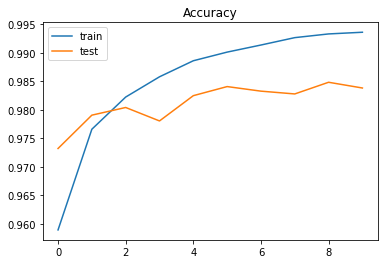

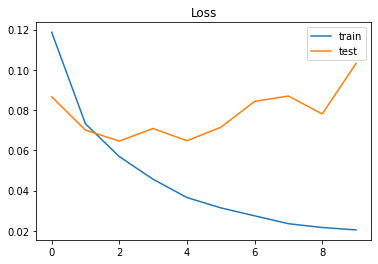

In [28]:
plot_history(history)

Quite overfitted. Training could stop after ~3 epochs and some regularizations (like dropout) could also make sense.  

**Node: Following output is from a build_model_cnn(...) run!**

Let's see if it is possible to further improve the model by unfreezing the embedding layer.

Also see https://www.tensorflow.org/guide/keras/transfer_learning

In [28]:
# Unfreeze all layers (i.e. make embeddings trainable)
model.trainable = True
model.summary()

Model: "cnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization (TextVect (None, None)              0         
_________________________________________________________________
embedding (Embedding)        (None, None, 300)         61647900  
_________________________________________________________________
conv_0 (Conv1D)              (None, None, 128)         268928    
_________________________________________________________________
max_pool_0 (MaxPooling1D)    (None, None, 128)         0         
_________________________________________________________________
conv_1 (Conv1D)              (None, None, 128)         114816    
_________________________________________________________________
global_max_pool_1 (GlobalMax (None, 128)               0         
_________________________________________________________________
global_max_pool_dropout (Dro (None, 128)               0       

In [29]:
re_compile_model(params, model)

In [30]:
params["training_epochs"] = 2
history = train_model(params, model, dataset_train, dataset_val)

Epoch 1/2
3512/3512 [==============================] - 1652s 470ms/step - loss: 0.1120 - accuracy: 0.9625 - val_loss: 0.1005 - val_accuracy: 0.9659
Epoch 2/2
3512/3512 [==============================] - 1658s 472ms/step - loss: 0.0911 - accuracy: 0.9701 - val_loss: 0.0910 - val_accuracy: 0.9697


In [ ]:
#%tensorboard --logdir logs

In [31]:

def plot_confusion_matrix(y_true, y_pred, title='', percentage=True, filename=None):
    """Plots or stores the confusion matrix 

    Parameters: 
        y_true: list/array
            The true labels
        y_pred: list/array
            The predicted labels
        title: str
            The title of the plot
        percentage: bool 
            Defines if percentage or number of samples should be printed for each category
        filename: str
            The path and name of the file to save the confusion matrix (will not be plotted to the screen if set)
    """
    
    import matplotlib.pyplot as plt
    from sklearn.metrics import confusion_matrix
    
    classes = list(set(list(y_true) + list(y_pred)))
    classes.sort()

    cmm = confusion_matrix(y_true, y_pred)

    print('Set Population: {}'.format(cmm.sum()))
    print('Accuracy: {:.4f}'.format(float(cmm.trace()) / cmm.sum()))

    plt.figure(figsize=(10, 8))
    plt.imshow(np.flip(cmm / cmm.sum(), 0), interpolation='nearest', cmap='Blues')
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.colorbar()

    plt.ylim(-0.5, len(classes)-0.5)

    if classes is not None:
        tick_marks = np.arange(len(classes))
        plt.xticks(tick_marks, classes, rotation=45, size='x-large')
        plt.yticks(np.flip(tick_marks), classes, size='x-large')

    cmm_flip = np.flip(cmm, 0)
    for y in range(cmm.shape[0]):
        for x in range(cmm.shape[1]):
            if cmm_flip[y, x] > 0:
                if percentage:
                    plt.text(x, y, '%.3f' % ((cmm_flip[y, x] / cmm.sum())),
                         horizontalalignment='center',
                         verticalalignment='center')
                else:
                    plt.text(x, y, '%.0i' % cmm_flip[y, x],
                         horizontalalignment='center',
                         verticalalignment='center')
    
    if filename is not None:
        plt.savefig(filename, dpi=300)
    else: 
        plt.show()


def predict_classification(params, data, model):
    """Predicts the classes 

    Parameters
    ----------
    params: dict
        The dictionary containing the parameters
    data: dataframe
        The data
    model: model
        The keras model
        
    Returns
    -------
    lists/arrays
        The true labels (ground truth), the predicted labels, and the prediction probabilities
    """
    
    import numpy as np
        
    batch_size = 2 * params.get("batch_size", 64)
    y_column_name = params.get("y_column_name", "label")
    X_column_name = params.get("X_column_name", "text_clean")
    prediction_probability_threshold = params.get("prediction_probability_threshold", 0.5)
    computed_objects_column_name = params.get("computed_objects_column_name", "computed_objects")
    label_binarizer = params[computed_objects_column_name]["label_binarizer"]
    
    y = data[y_column_name]
    
    y_pred_prob = model.predict(data[X_column_name], batch_size=batch_size)
    y_pred = label_binarizer.inverse_transform(y_pred_prob, threshold=prediction_probability_threshold)                                             
    
    params["labels"] = y
    params["labels_predicted"] = y_pred
    params["labels_predicted_probability"] = y_pred_prob
    
    return (y, y_pred, y_pred_prob)


def report_classification_results(params, data, model):
    """Reports all classification results

    Parameters: 
        params: dict
            The dictionary containing the parameters
        data: dataframe
            The data
        model: model
            The keras model
    """
    
    from sklearn.metrics import classification_report
    
    verbose = params.get("verbose", False)
    path = params.get("model_path")

    y, y_pred, y_pred_prob = predict_classification(params, data, model)
    
    if path is not None:
        path_confusion_matrix = os.path.join(path, "confusion_matrix.png")
        plot_confusion_matrix(y, y_pred, filename=path_confusion_matrix)
    if verbose:
        plot_confusion_matrix(y, y_pred)
        
    if path is not None:
        path_classification_report = os.path.join(path, "classification_report.csv")
        report = classification_report(y, y_pred, output_dict=True)
        report = pandas.DataFrame(report).transpose()
        report.to_csv(path_classification_report)
    if verbose:
        report = classification_report(y, y_pred)
        print(report)

Check performance on all data.

Set Population: 331187
Accuracy: 0.9511


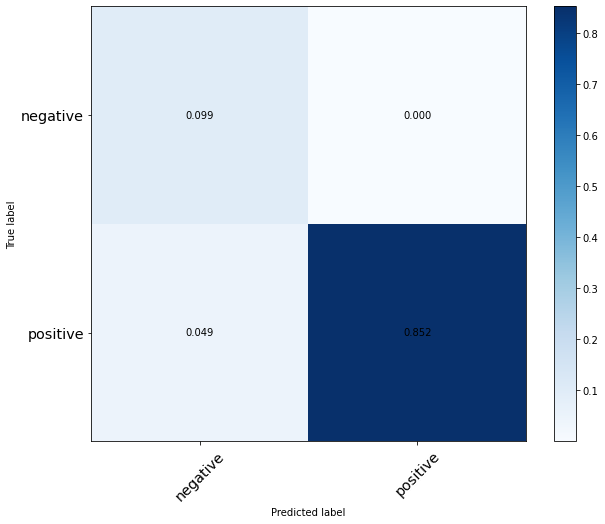

              precision    recall  f1-score   support

    negative       0.67      1.00      0.80     33022
    positive       1.00      0.95      0.97    298165

    accuracy                           0.95    331187
   macro avg       0.84      0.97      0.89    331187
weighted avg       0.97      0.95      0.96    331187

CPU times: user 1min 57s, sys: 755 ms, total: 1min 58s
Wall time: 57.4 s


In [32]:
%%time

report_classification_results(params, data, model)

Check performance on test data.

Set Population: 66238
Accuracy: 0.9434


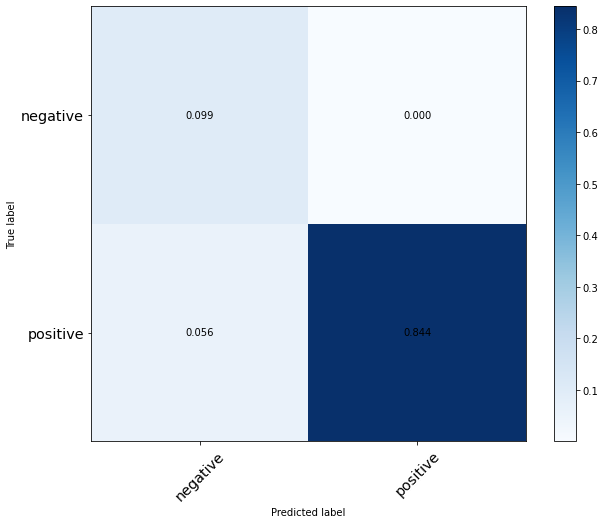

              precision    recall  f1-score   support

    negative       0.64      1.00      0.78      6604
    positive       1.00      0.94      0.97     59634

    accuracy                           0.94     66238
   macro avg       0.82      0.97      0.87     66238
weighted avg       0.96      0.94      0.95     66238

CPU times: user 20.8 s, sys: 120 ms, total: 20.9 s
Wall time: 8.62 s


In [33]:
%%time

report_classification_results(params, data_test, model)